# This is the Notebook for SWAE on the MNIST Dataset

This notebook implements Sliced Wasserstein Auto-Encoders (SWAE).

To run this notebook you'll require the following packages:

* Numpy
* Matplotlib
* tensorflow
* Keras
* h5py


In [1]:
import numpy as np
import keras.utils
from keras.layers import Input,Dense, Flatten
from keras.models import load_model, Model
from keras.layers import Conv2D, UpSampling2D, AveragePooling2D,Lambda
from keras.layers import LeakyReLU,Reshape
from keras.datasets import mnist
from keras.models import save_model
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import time

Using TensorFlow backend.


## Define three helper functions
 * generateTheta(L,dim) -> Generates $L$ random sampels from $\mathbb{S}^{dim-1}$
 * generateZ(batchsize,endim) -> Generates 'batchsize' samples 'endim' dimensional samples from $q_Z$ 
 * stitchImages(I,axis=0) -> Helps us with visualization

In [2]:
def generateTheta(L,endim):
    # This function generates L random samples from the unit `ndim'-u
    theta=[w/np.sqrt((w**2).sum()) for w in np.random.normal(size=(L,endim))]
    return np.asarray(theta)
def generateZ(batchsize):
    # This function generates 2D samples from a `circle' distribution in 
    # a 2-dimensional space
    r=np.random.uniform(size=(batchsize))
    theta=2*np.pi*np.random.uniform(size=(batchsize))
    x=r*np.cos(theta)
    y=r*np.sin(theta)
    z_=np.array([x,y]).T
    return z_
def stitchImages(I,axis=0):
    n,N,M,K=I.shape
    if axis==0:
        img=np.zeros((N*n,M,K))
        for i in range(n):
            img[i*N:(i+1)*N,:,:]=I[i,:,:,:]
    else:
        img=np.zeros((N,M*n,K))
        for i in range(n):
            img[:,i*M:(i+1)*M,:]=I[i,:,:,:]
    return img

## Defining the Encoder/Decoder as Keras graphs

In this section we define our encoder-decoder architectures and the corresponding loss function for the SWAE. 

In [3]:
img=Input((28,28,1)) #Input image 
interdim=128 # This is the dimension of intermediate latent variable 
             #(after convolution and before embedding)
endim=2 # Dimension of the embedding space
embedd=Input((endim,)) #Keras input to Decoder
depth=16 # This is a design parameter and in fact it is not the depth!
L=50 # Number of random projections
batchsize=500 

W1216 11:28:05.533363 12272 deprecation_wrapper.py:119] From C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1216 11:28:05.561666 12272 deprecation_wrapper.py:119] From C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



### Define Encoder

In [4]:

x=Conv2D(depth*1, (3, 3), padding='same')(img)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*1, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=AveragePooling2D((2, 2), padding='same')(x)
x=Conv2D(depth*2, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*2, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=AveragePooling2D((2, 2), padding='same')(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=AveragePooling2D((2, 2), padding='same')(x)
x=Flatten()(x)
x=Dense(interdim,activation='relu')(x)
encoded=Dense(endim)(x)

encoder=Model(inputs=[img],outputs=[encoded])
encoder.summary()

W1216 11:28:05.589971 12272 deprecation_wrapper.py:119] From C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1216 11:28:05.654386 12272 deprecation_wrapper.py:119] From C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4640      
__________

In [5]:
def mean(x):
    return K.mean(x, axis=0, keepdims=False)

In [6]:
img_theta=Input((28,28,1))
x=Conv2D(depth*1, (3, 3), padding='same')(img_theta)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*1, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=AveragePooling2D((2, 2), padding='same')(x)
x=Conv2D(depth*2, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*2, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=AveragePooling2D((2, 2), padding='same')(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=AveragePooling2D((2, 2), padding='same')(x)
x=Flatten()(x)
x=Dense(interdim,activation='relu')(x)
theta_1=Dense(endim*L)(x)
theta_1=Lambda(lambda x: mean(x))(theta_1)
nn_theta=Model(inputs=[img_theta],outputs=[theta_1])

In [7]:
nn_theta.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        4640      
__________

### Define Decoder

In [5]:
x=Dense(interdim)(embedd)
x=Dense(depth*64,activation='relu')(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Reshape((4,4,4*depth))(x)
x=UpSampling2D((2, 2))(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
x=UpSampling2D((2, 2))(x)
x=Conv2D(depth*4, (3, 3), padding='valid')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
x=UpSampling2D((2, 2))(x)
x=Conv2D(depth*2, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*2, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
# x=BatchNormalization(momentum=0.8)(x)
decoded=Conv2D(1, (3, 3), padding='same',activation='sigmoid')(x)

decoder=Model(inputs=[embedd],outputs=[decoded])
decoder.summary()

W1216 11:28:05.960846 12272 deprecation_wrapper.py:119] From C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              132096    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

Here we define Keras variables for $\theta$ and sample $z$s.

In [6]:
theta=K.variable(generateTheta(L,endim)) #Define a Keras Variable for \theta_ls
#theta=nn_theta(img)
z=K.variable(generateZ(batchsize)) #Define a Keras Variable for samples of z

Put encoder and decoder together to get the autoencoder

In [7]:
# Generate the autoencoder by combining encoder and decoder
aencoded=encoder(img)
ae=decoder(aencoded)
autoencoder=Model(inputs=[img],outputs=[ae])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 203250    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         308193    
Total params: 511,443
Trainable params: 511,443
Non-trainable params: 0
_________________________________________________________________


In [8]:
#theta=tf.reshape(theta,[50,2])

In [8]:
# Let projae be the projection of the encoded samples
projae=K.dot(aencoded,K.transpose(theta))
# Let projz be the projection of the $q_Z$ samples
projz=K.dot(z,K.transpose(theta))
# Calculate the Sliced Wasserstein distance by sorting 
# the projections and calculating the L2 distance between
W2=(tf.nn.top_k(tf.transpose(projae),k=batchsize).values-
    tf.nn.top_k(tf.transpose(projz),k=batchsize).values)**2

In [34]:
z

<tf.Variable 'Variable_1:0' shape=(500, 2) dtype=float32_ref>

In [35]:
aencoded#(batchsize,endim)=(500,2)

<tf.Tensor 'model_1/dense_2/BiasAdd:0' shape=(?, 2) dtype=float32>

In [30]:
theta

<tf.Variable 'Variable:0' shape=(50, 2) dtype=float32_ref>

In [27]:
projae

<tf.Tensor 'MatMul:0' shape=(?, 50) dtype=float32>

In [28]:
projz

<tf.Tensor 'MatMul_1:0' shape=(500, 50) dtype=float32>

In [29]:
W2

<tf.Tensor 'pow:0' shape=(50, 500) dtype=float32>

In [9]:
w2weight=K.variable(10.0)
crossEntropyLoss= (1.0)*K.mean(K.binary_crossentropy(K.flatten(img),K.flatten(ae)))
L1Loss= (1.0)*K.mean(K.abs(K.flatten(img)-K.flatten(ae)))
W2Loss= w2weight*K.mean(W2)
# I have a combination of L1 and Cross-Entropy loss for the first term and then 
# W2 for the second term
vae_Loss=L1Loss+crossEntropyLoss+W2Loss
autoencoder.add_loss(vae_Loss) # Add the custom loss to the model

W1216 11:28:44.611767 12272 deprecation_wrapper.py:119] From C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W1216 11:28:44.616649 12272 deprecation.py:323] From C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
#Compile the model
autoencoder.compile(optimizer='rmsprop')

W1216 11:28:45.758963 12272 deprecation_wrapper.py:119] From C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [11]:
autoencoder.metrics_tensors.append(L1Loss)
autoencoder.metrics_names.append("l1_loss")

autoencoder.metrics_tensors.append(crossEntropyLoss)
autoencoder.metrics_names.append("crossEntropyLoss")

autoencoder.metrics_tensors.append(W2Loss)
autoencoder.metrics_names.append("w2_loss")

### Load the MNIST dataset

In [12]:
(x_train,y_train),(x_test,_)=mnist.load_data()
x_train=np.expand_dims(x_train.astype('float32')/255.,3)

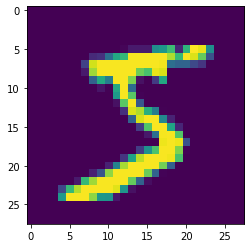

In [13]:
plt.imshow(np.squeeze(x_train[0,...]))
plt.show()

## Optimize the Loss

In [82]:
loss=[]
fig1=plt.figure()
for epoch in range(60):
    ind=np.random.permutation(x_train.shape[0])    
    if epoch>10:
        K.set_value(w2weight,1.1*K.eval(w2weight))
    for i in range(int(x_train.shape[0]/batchsize)):
        Xtr=x_train[ind[i*batchsize:(i+1)*batchsize],...]
        theta_=generateTheta(L,endim)
        z_=generateZ(batchsize)
        K.set_value(z,z_)
        K.set_value(theta,theta_)        
        loss.append(autoencoder.train_on_batch(x=Xtr,y=None))
        if loss[-1][0]>5.0:
            break
        print('Epoch:', epoch, 'iterate:', i, loss[-1])
    if loss[-1][0]>5.0:
        break
    plt.plot(np.asarray(loss))
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    time.sleep(1e-3) 

FailedPreconditionError: Attempting to use uninitialized value training/RMSprop/Variable_6
	 [[{{node training/RMSprop/Variable_6/read}}]]

<Figure size 432x288 with 0 Axes>

In [88]:
Xtr.shape

(500, 28, 28, 1)

In [49]:
autoencoder.predict(Xtr).shape

(500, 28, 28, 1)

In [81]:
aaa=encoder.predict(Xtr)

FailedPreconditionError: Attempting to use uninitialized value conv2d_4/kernel
	 [[{{node conv2d_4/kernel/read}}]]

In [59]:
aaa=tf.convert_to_tensor(aaa)

In [76]:
projae=K.dot(aaa,K.transpose(theta))
# Let projz be the projection of the $q_Z$ samples
projz=K.dot(z,K.transpose(theta))

In [85]:
projae

<tf.Tensor 'MatMul_4:0' shape=(500, 50) dtype=float32>

In [77]:
W2=(tf.nn.top_k(tf.transpose(projae),k=batchsize).values-
    tf.nn.top_k(tf.transpose(projz),k=batchsize).values)**2

In [78]:
W2Loss= w2weight*K.mean(W2)

In [84]:
with tf.Session() as sess:  print(W2.eval()) 

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[node Variable/read (defined at C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:402) ]]

Original stack trace for 'Variable/read':
  File "C:\Tools\Anaconda\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 563, in start
    self.io_loop.start()
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Tools\Anaconda\envs\tensorflow\lib\asyncio\base_events.py", line 534, in run_forever
    self._run_once()
  File "C:\Tools\Anaconda\envs\tensorflow\lib\asyncio\base_events.py", line 1771, in _run_once
    handle._run()
  File "C:\Tools\Anaconda\envs\tensorflow\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tornado\gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tornado\gen.py", line 714, in __init__
    self.run()
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-0c6e80adc083>", line 1, in <module>
    theta=K.variable(generateTheta(L,endim)) #Define a Keras Variable for \theta_ls
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 402, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2511, in default_variable_creator
    shape=shape)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 1568, in __init__
    shape=shape)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 1755, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\util\dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py", line 86, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 4252, in identity
    "Identity", input=input, name=name)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [42]:
np.save('w2_explode.npy',loss)

In [17]:
'''loss=[]
fig1=plt.figure()
for epoch in range(60):
    ind=np.random.permutation(x_train.shape[0])    
    if epoch>10:
        K.set_value(w2weight,1.1*K.eval(w2weight))
    for i in range(int(x_train.shape[0]/batchsize)):
        Xtr=x_train[ind[i*batchsize:(i+1)*batchsize],...]
        Xtr_=tf.convert_to_tensor(Xtr)
        theta=nn_theta(Xtr_)
        z_=generateZ(batchsize)
        K.set_value(z,z_)
        #K.set_value(theta,theta_)        
        loss.append(autoencoder.train_on_batch(x=Xtr,y=None))
    plt.plot(np.asarray(loss))
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    time.sleep(1e-3) '''

W1216 00:36:26.698176 16772 deprecation_wrapper.py:119] From C:\Tools\Anaconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

## Encode and decode x_train

In [35]:
# Test autoencoder
en=encoder.predict(x_train)# Encode the images
dec=decoder.predict(en) # Decode the encodings

In [33]:
en.shape

(60000, 2)

## Visualize the encoding space

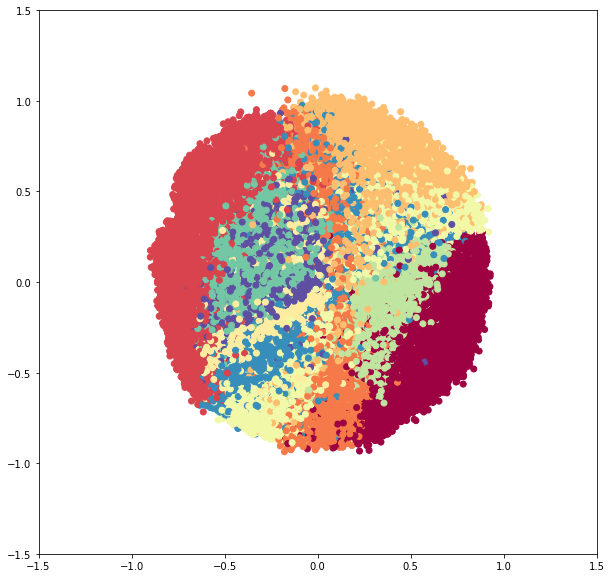

In [37]:
# Distribution of the encoded samples
plt.figure(figsize=(10,10))
plt.scatter(en[:,0],-en[:,1],c=10*y_train, cmap=plt.cm.Spectral)
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.show()

### Sample a grid in the encoding space and decode it to visualize this space

In [17]:
#Sample the latent variable on a Nsample x Nsample grid
Nsample=25
hiddenv=np.meshgrid(np.linspace(-1,1,Nsample),np.linspace(-1,1,Nsample))
v=np.concatenate((np.expand_dims(hiddenv[0].flatten(),1),
                  np.expand_dims(hiddenv[1].flatten(),1)),1)
# Decode the grid
decodeimg=np.squeeze(decoder.predict(v))

In [18]:
#Visualize the grid 
count=0
img=np.zeros((Nsample*28,Nsample*28))
for i in range(Nsample):
    for j in range(Nsample):        
        img[i*28:(i+1)*28,j*28:(j+1)*28]=decodeimg[count,...]
        count+=1

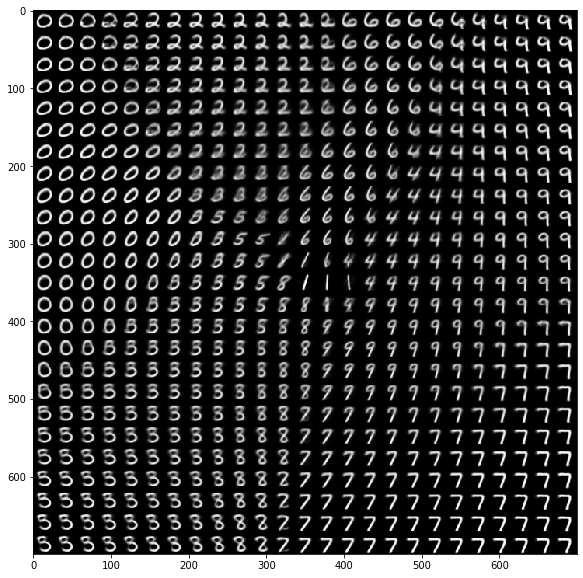

In [19]:
fig=plt.figure(figsize=(10,10))
plt.imshow(img,cmap='gray')
plt.show()

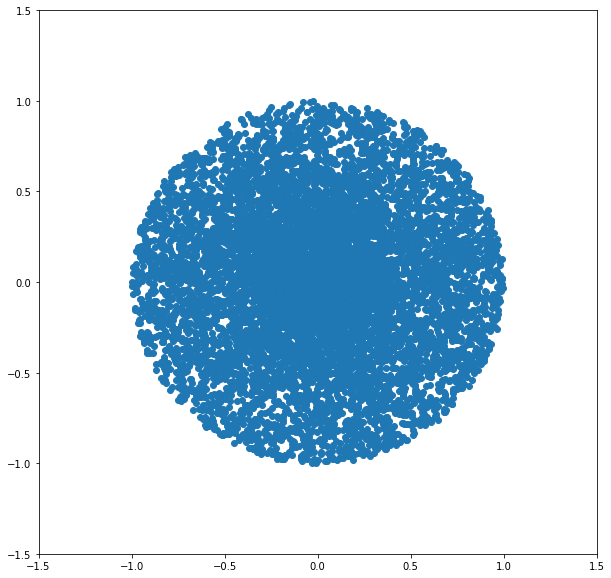

In [20]:
#Visualize the z samples
plt.figure(figsize=(10,10))
Z=generateZ(10000)
plt.scatter(Z[:,0],Z[:,1])
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.show()

### Save the trained models! 

In [40]:
np.array(loss[59*120:]).max()

8.063146

In [41]:
np.array(loss[59*120:])

array([[1.8339719 , 0.09619463, 0.19095883, 1.5468184 ],
       [1.6022111 , 0.09348985, 0.19232094, 1.3164003 ],
       [3.429837  , 0.09390375, 0.18888241, 3.1470509 ],
       [2.2065296 , 0.09499484, 0.19585258, 1.9156822 ],
       [2.9456024 , 0.09729865, 0.19523557, 2.653068  ],
       [2.100328  , 0.09961582, 0.20375988, 1.7969522 ],
       [1.7408307 , 0.09877581, 0.1925088 , 1.4495461 ],
       [1.3671204 , 0.0941776 , 0.19786605, 1.0750767 ],
       [1.7887597 , 0.10009676, 0.20004408, 1.4886189 ],
       [3.2179103 , 0.09459084, 0.19310842, 2.930211  ],
       [1.9217589 , 0.09864351, 0.19642547, 1.6266899 ],
       [1.2073139 , 0.09595341, 0.19805208, 0.9133084 ],
       [2.2728128 , 0.09977716, 0.1988851 , 1.9741505 ],
       [5.1219463 , 0.09437606, 0.1931324 , 4.834438  ],
       [5.089957  , 0.09860624, 0.1980407 , 4.79331   ],
       [3.1032295 , 0.1001009 , 0.20174053, 2.801388  ],
       [3.4202166 , 0.09986271, 0.1986028 , 3.121751  ],
       [1.7894065 , 0.093205  ,

In [20]:
save_model(encoder,filepath='MNIST_circle_encoder.h5')
save_model(decoder,filepath='MNIST_circle_decoder.h5')
save_model(autoencoder,filepath='MNIST_circle_autoencoder.h5')

## Generate random samples with respect to $q_Z$.

In [21]:
randomSamples=generateZ(Nsample**2)
randomdecodeimg=np.squeeze(decoder.predict(randomSamples))

In [22]:
imgRandom=np.zeros((Nsample*28,Nsample*28))
count=0
for i in range(Nsample):
    for j in range(Nsample):        
        imgRandom[i*28:(i+1)*28,j*28:(j+1)*28]=randomdecodeimg[count,...]
        count+=1

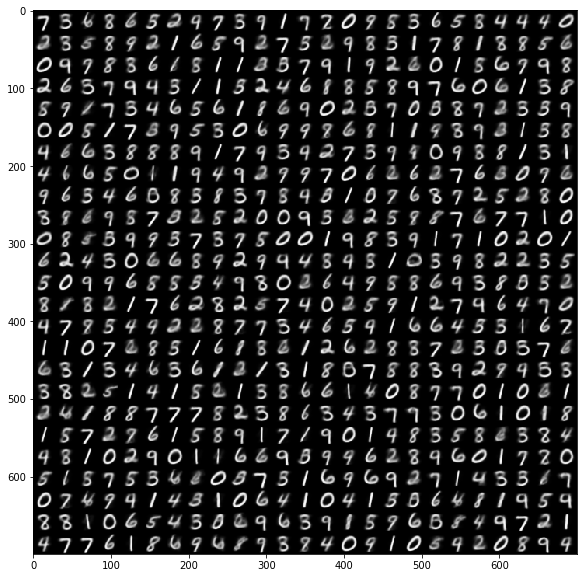

In [23]:
fig=plt.figure(figsize=(10,10))
plt.imshow(imgRandom,cmap='gray')
plt.show()

In [90]:
from matplotlib import pyplot as plt

<Figure size 864x1152 with 0 Axes>

<Figure size 864x1152 with 0 Axes>

In [91]:
loss_random=np.load('loss_random_sampled_theta.npy')

In [93]:
loss_theta=np.load('loss_adaptive_theta.npy')

In [94]:
loss_theta=np.array(loss_theta)
loss_random=np.array(loss_random)

In [105]:
(loss_random[:,0]-loss_theta[:,0]).mean()

-0.008785332

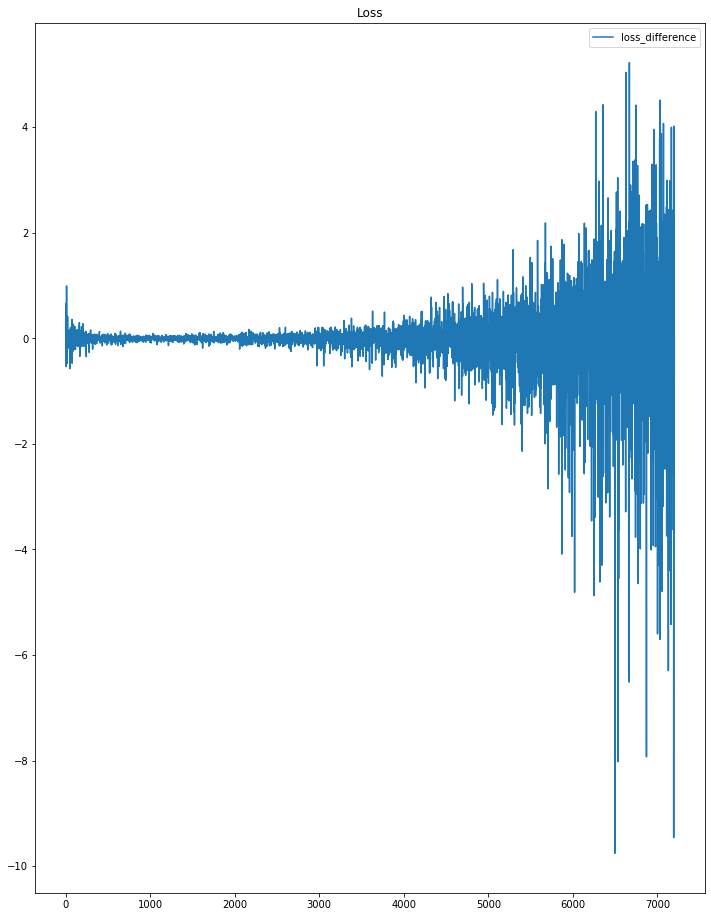

In [114]:
plt.figure(figsize=(12, 16))
plt.plot(range(1,7201),loss_random[:,0]-loss_theta[:,0],'-',label='loss_difference')
plt.legend()
plt.title('Loss')
plt.savefig('loss difference.png')

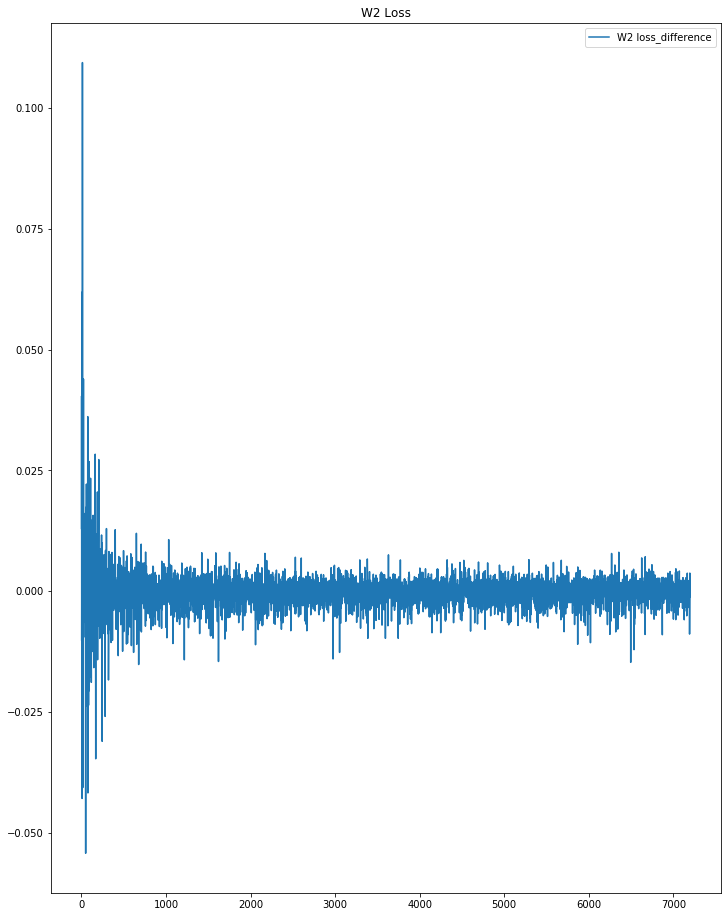

In [117]:
plt.figure(figsize=(12, 16))
plt.plot(range(1,7201),loss_random[:,3]/loss_random[:,4]-loss_theta[:,3]/loss_random[:,4],'-',label='W2 loss_difference')
plt.legend()
plt.title('W2 Loss')
plt.savefig('W2 loss difference.png')

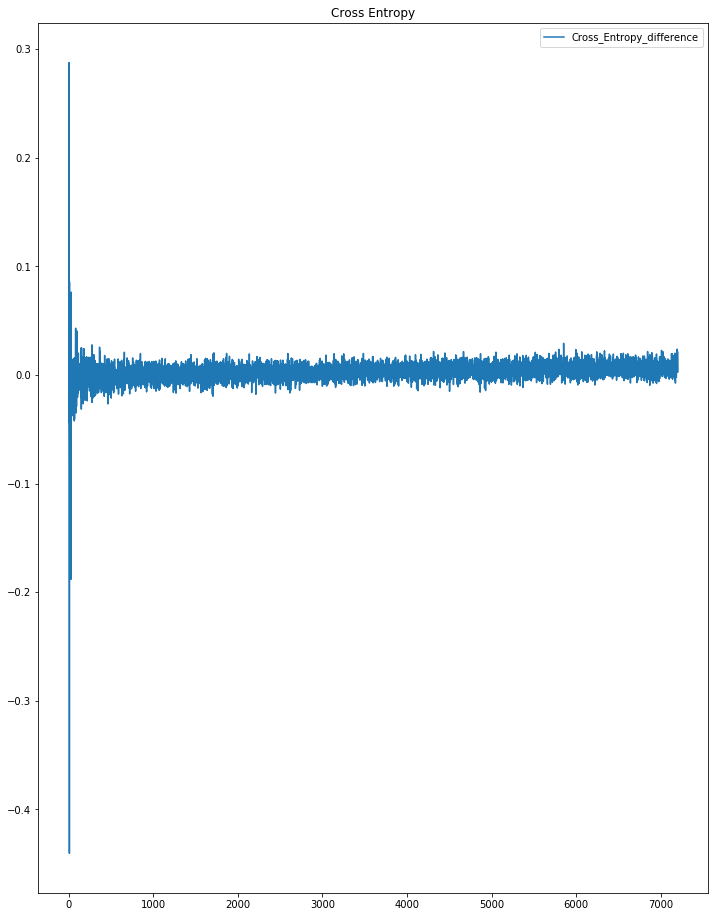

In [118]:
plt.figure(figsize=(12, 16))
plt.plot(range(1,7201),loss_random[:,2]-loss_theta[:,2],'-',label='Cross_Entropy_difference')
plt.legend()
plt.title('Cross Entropy')
plt.savefig('Cross Entropy difference.png')